# jPCA as a constrained LDS

_jPCA_ is a dimensionality reduction technique for neuroscience developed in Churchland _et al_. (2012) "Structure of neural population dynamics during reaching." _Nature_. The paper uses the jPCA dimensionality reduction technique to find oscillatory structure in neural recordings from monkeys during reaching. The following notebook demonstrates that jPCA can be thought of as learning a linear dynamical system (LDS) with a constraint on the $A$ matrix. A link to the original paper is [here](https://www.nature.com/articles/nature11129)

### 1. The generative model for jPCA is a simple Linear Dynamical System
$$\newcommand{\R}{\mathbb{R}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\Y}{\mathbf{Y}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\X}{\mathbf{X}}
\newcommand{\Normal}{\mathcal{N}}
\newcommand{\Poiss}{\textnormal{Poiss}}
\DeclareMathOperator{\E}{\mathbb{E}}
\DeclareMathOperator{\tr}{\textnormal{tr}}
$$

We assume that we have measured some neural state $\x(t) \in \R^D$. Most often, PCA or another form of dimensionality reduction is applied as a preprocessing step, so that $D$ is less than the full dimensionality of the data, but this doesn't change any of the underlying ideas. The key assumption is that the neural state evolves according to simple linear dynamics:
\begin{equation}
    \dot{\x}(t) = M \x(t) \label{orig_lds}
\end{equation}

The original motivation for jPCA came from the assumption that the system should represent rotational transformations of the state vector, rather than expansions or contractions. This corresponds to constraining the dynamics matrix $M$ to be skew-symmetric ($M=-M^T$).

Standard jPCA estimates $M$ by solving a least-squares optimization problem. Since we have not directly observed $\dot\x(t)$, Churchland _et al_ approximate it using a first-difference: $\dot\x(t) \approx \x(t+\tau) - \x(t)$. Equivalently, in discrete time, $\dot\x_t \approx \x_{t+1} - \x_t$. Under this approximation, we can estimate $M$ by solving a least-squares problem where the objective is $\sum_{k=2}^K \| \x_{k} - \x_{k-1} - M\x_{k-1} \|_2^2$ subject to the constraint that $M$ is Skew-Symmetric.

The choice to use least-squares is equivalent to choosing a Gaussian noise model for the dynamics with identity covariance, and to assuming that we observe the state directly.

### 2. A probabilistic approach to jPCA

We can alternatively formulate jPCA by considering a linear dynamical system in discrete time:

\begin{equation*}
	\x_{k+1} = A \x_{k} + \epsilon
\end{equation*}

where epsilon is a (typically Gaussian) noise variable. If we constrain $A$ to be orthogonal, the system will represent rotations. Since SSM allows us to learn discrete-time linear dynamical systems from data, we can then use SSM to estimate the matrix $A$ using a modified EM algorithm where $A$ is constrained to be orthogonal during the M-Step. The probabilistic formulation allows us to include non-Gaussian measurement models (like Poisson models of spiking activity) as well as handle missing data.

One point of subtlety: constraining $A$ to be orthogonal is not enough to guarantee that the system will rotational. An orthogonal matrix can represent either a rotation (determinant 1) or a reflection (determinant -1). When learning the matrix $A$, we will take care to ensure that all eigenvalues are 1.


### 3. Computing the jPCA projections

Once we have estimated the matrix $A$ using SSM, we will need to project our data onto a 2-dimensional plane in order to visualize the rotations. Although our formulation differs slightly from the original formulation of jPCA (we have used a discrete-time system instead of continuous), the projection step works in the same way.

We compute the eigenvectors and eigenvalues of $A$. Each eigenvector and eigenvalue come in complex conjugate pairs. To find the plane of strongest rotation, we look at the plane spanned by the two eigenvectors associated with eigenvalues that have large imaginary components.

As a concrete example, we might have an $A$ matrix with the following eigenvalues: $0.92 + 0.15i, 0.92 - 0.15i, 0.98 + 0.04i, 0.98 - 0.04i$. The first two eigenvalues have the largest imaginary components, so we would look at the plane spanned by the first two eigenvectors ($V_1$ and $V_2$) in order to capture the strongest rotations. Though the eigenvectors are complex, following Churchland _et al_ we can find real vectors to project onto: $jPC_1 = V_1 + V_2$, $jPC_2 = i(V_1 - V_2)$. We have added a convenience function to ssm.util called `jPCA_project` which takes care of this process. Following the jPCA Matlab implementation, it also rotates the jPCs so that the starting points of the trajectories are spread along the horizontal axis.  
  




In [21]:
import numpy as np
import matplotlib.pyplot as plt
import ssm

import jPCA
from jPCA.util import load_churchland_data, plot_projections

# Original jPCA

The data we'll use in this demo is trial-averaged data from Churchland _et al_ 2012. It is available online at this [link](https://churchland.zuckermaninstitute.columbia.edu/content/code). The dataset consists of recordings from a monkey performing reaching tasks across a variety of conditions. In the task, the monkey is required to move his hand through a maze. Each different maze configuration corresponds to a different trial condition (108 conditions in all).

The data is processed using the following steps: 
1. **Normalization**. Each neurons firing rate is normalized to fall roughly in the same range.
2. **Mean Subtraction.** The cross-condition mean (mean across all conditions) is subtracted. This is because there is a large condition-independent change in the data, and subtracting it allows us to see rotations across conditions.
3. **PCA.** The data is projected on the first few (default 6) principle components.

These preprocessing steps are defined in more detail in Churchland _et al_ 2012, and in Mark Churchland's notes on jPCA, found at the above link. We have written a Python implementation of jPCA which takes care of the data importing and preprocessing. It is available at: https://github.com/bantin/jPCA

Text(0.5, 1.0, 'Low Dimensional Trajectories with original jPCA')

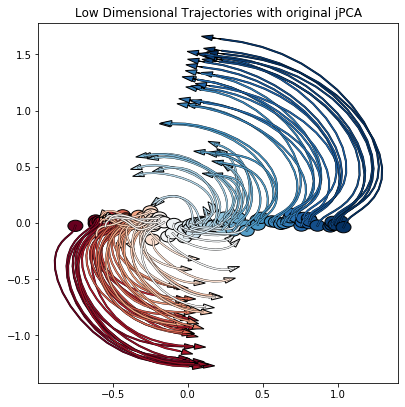

In [32]:
import jPCA
from jPCA.util import load_churchland_data, plot_projections, preprocess

# Load publicly available data from Mark Churchland's group
path = "/Users/Bantin/Documents/Stanford/Linderman-Shenoy/jPCA_ForDistribution/exampleData.mat"
datas, times = load_churchland_data(path)

# Create a jPCA object
jpca = jPCA.JPCA(num_jpcs=2)

# Fit the jPCA object to data
(jpca_projected, 
 full_data_var,
 pca_var_capt,
 jpca_var_capt) = jpca.fit(datas, times=times, tstart=-50, tend=150, num_pcs=6)

# Plot the projected data
plot_projections(projected)
plt.title("Low Dimensional Trajectories with original jPCA")

# 2. Probabilistic jPCA (pjPCA)

In order to replicate the results of traditional jPCA, we have the latent dimension ($D$) to 6. Importantly, though, we do not need to perform PCA as a preprocessing step. Instead, our emissions model, which is constrained to be orthogonal, takes the place of PCA.

The following line create an LDS with rotational dynamics:
```python
lds = ssm.LDS(N, D, dynamics="rotational", emissions="gaussian_orthog")
```
Setting `dynamics="rotational"` will ensure that the $A$ matrix we recover is orthogonal. After obtaining an orthogonal emissions matrix $A$, we can use the same procedure as regular JPCA to visualize the rotationas.

In [23]:
D = 6
N = datas[0].shape[1]

# Truncate data to -50 to 150 ms, and subtract the cross-condition mean
datas_truncated, full_data_var, _ = preprocess(datas, times, tstart=-50, tend=150, pca=False)

Initializing with an ARHMM using 25 steps of EM.


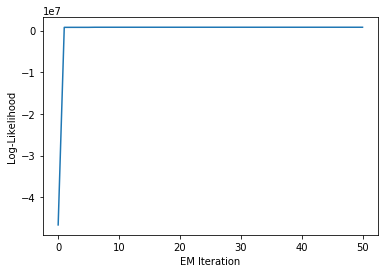

In [24]:
lds = ssm.LDS(N, D, dynamics="rotational", emissions="gaussian_orthog")
elbos, posterior = lds.fit(datas_truncated, num_iters=50)
plt.plot(elbos)
plt.xlabel("EM Iteration")
plt.ylabel("Log-Likelihood")
plt.show()

### 2.1 Visualizing Rotations

Once we have learned our LDS, we are interested in two quantities: the posterior distribution over the latent states (this is equivalent to smoothing the data with a Kalman smoother), and the orthogonal dynamics matrix $A$.

We then use the real modal form function to find a projection of our states in which they are decoupled. This is equivalent to the visualiztion technique used by JPCA (need to prove).

Text(0.5, 1.0, 'First jPCA Plane, probabilistic jPCA')

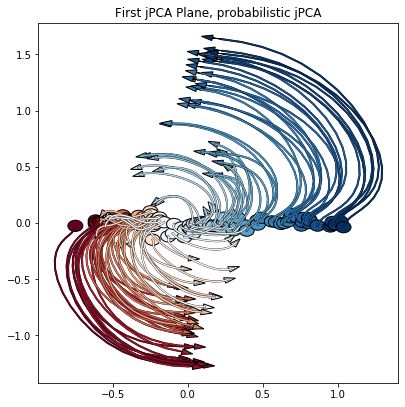

In [36]:
from ssm.util import real_modal_form

# Create a jPCA object and set the jPCS using the matrix recovered from Laplace-EM
A_inf = lds.dynamics.A
pjpca = jPCA.JPCA(num_jpcs=6)
pjpca.jpcs = pjpca._calculate_jpcs(A_inf)
pjpca.align_jpcs(x_inf)
pjpca_projected, _ = pjpca.project(x_inf)


# The x and y axes are coming out flipped for some reason.
# For now, manually swap them so it's easier to compare figures.
plot_projections(pjpca_projected, x_idx=0, y_idx=1)
plt.title("First jPCA Plane, probabilistic jPCA")

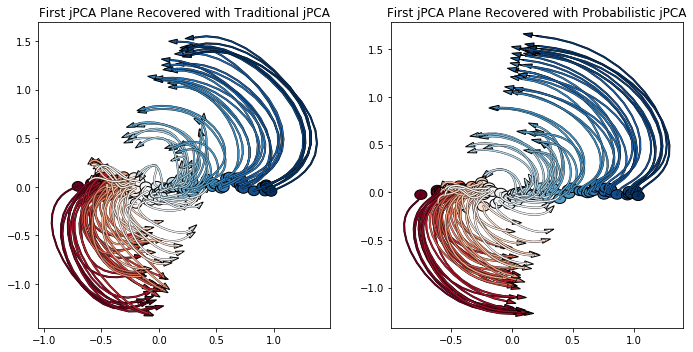

In [37]:
# Side-by-side comparison
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_projections(jpca_projected, axis=ax[0])
plot_projections(pjpca_projected, axis=ax[1])

ax[0].set_title("First jPCA Plane Recovered with Traditional jPCA")
ax[1].set_title("First jPCA Plane Recovered with Probabilistic jPCA")

plt.tight_layout()
plt.show()